# Defective PV Module Cells Classification Model

Si bien en general los módulos fotovoltaicos presentan un marco de aluminio y una superficie de vidrio para proteger las celdas solares en su interior, la verdad es que estas medidas de protección no siempre serán capaces de prevenir ni evitar la falla de las celdas fotovolaticas u otros elementos durante su vida útil. En este sentido, dado que las celdas defectuosas conducen directamente a una caída en la eficiencia de generación eléctrica en el módulo, monitorear continuamente el estado de estos activos permite mejorar significativamente la operación y el mantenimiento de, por ejemplo, una planta fotovoltaica.

<img src="https://raw.githubusercontent.com/cherrerab/deeplearningfallas/master/workshop_03/bin/banner.png" height="180">

Entre los métodos que permiten llevar a cabo una inspección visual de la condición de las celdas solares, las imágenes de electroluminiscencia (EL) proveen de imágenes de alta resolución que posibilitan la detección de defectos de menor tamaño en la superficie de las celdas. No obstante, por lo general el análisis de estas imágenes consiste en un proceso manual y tedioso que en la mayoría de los casos requiere de técnicos especializados.

## ELPV Dataset

En este workshop dispondremos de un dataset público de imágenes de electroluminiscencia de celdas solares fotovoltaicas en distintos estado de daño con el cual desarrollaremos y entrenaremos un modelo de diagnóstico mediante redes convolucionales (CNN). En particular, el datset que utilizaremos cuenta con `2624` imágenes de `300x300 px`, en escala de grises, con distintos niveles de degradación. De este modo, cada imagen o muestra cuenta con una etiqueta que indica la probabilidad, estimada bajo la evaluación de un experto, de que la muestra presente un estado defectuoso.

El dataset se encuentra publicado en un repositorio github:
- https://github.com/zae-bayern/elpv-dataset

In [2]:
!git clone https://github.com/zae-bayern/elpv-dataset.git
%cd /content/elpv-dataset/utils

Cloning into 'elpv-dataset'...
remote: Enumerating objects: 2686, done.
remote: Total 2686 (delta 0), reused 0 (delta 0), pack-reused 2686
Receiving objects: 100% (2686/2686), 90.79 MiB | 12.94 MiB/s, done.
Resolving deltas: 100% (30/30), done.
/content/elpv-dataset/utils


El repositorio, además de contener las imágenes y etiquetas de probabilidad correspondientes, cuenta con la función `load_dataset` para importar los datos en un entorno de python. 

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from elpv_reader import load_dataset

# importar colección de imágenes y etiquetas
images, proba, types = load_dataset()

# print dimensiones de las variables importadas
print('images.shape: ', images.shape)
print('\nproba.shape: ', proba.shape)
print('\ntypes.shape: ', types.shape)

images.shape:  (2624, 300, 300)

proba.shape:  (2624,)

types.shape:  (2624,)


Así, al importar el dataset, contamos con los `np.array` `images`, `proba` y `types`, donde este último indica el tipo de celda, monocristalina o policristalina, al que corresponde cada muestra. Para analizar de mejor manera el contenido de estas variables, extraeremos una muestra de ejemplo:

sample probability:  1.0

sample type:  mono


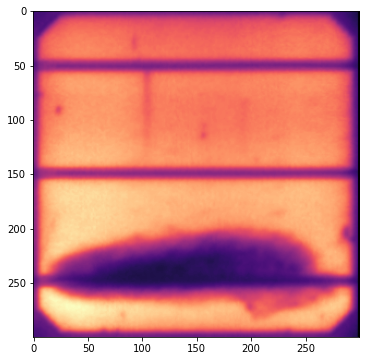

In [4]:
# extraer sample del dataset
sample_idx = 4
sample = np.reshape( images[sample_idx, :, :], (300, 300) )

# plot imagen
plt.figure( figsize=(6, 6) )
plt.imshow(sample, cmap='magma')

# print características
print('sample probability: ', proba[sample_idx])
print('\nsample type: ', types[sample_idx])

Ahora, de acuerdo a la descripción del dataset, las probabilidades en `proba` no siguen una distribución continua entre `[0.0, 1.0]`. En cambio, este valor depende de la incertidumbre del experto al realizar el diagnóstico de daño, como se muestra en la tabla a continuación. De este modo, podemos agrupar las imágenes del dataset de acuerdo su `proba` y luego visualizar cada grupo por separado para observar si estos presentan patrones o características que puedan facilitar la clasificación.

<img src="https://raw.githubusercontent.com/cherrerab/deeplearningfallas/master/workshop_03/bin/data_table.png" height="140">

Para la visualización de las muestras utilizaremos la función `plot_img_samples` presente en el módulo `utils` en el github del curso.

In [5]:
%cd /content/
!git clone https://github.com/cherrerab/deeplearningfallas.git
%cd /content/deeplearningfallas

/content
Cloning into 'deeplearningfallas'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 267 (delta 4), reused 0 (delta 0), pack-reused 249
Receiving objects: 100% (267/267), 22.93 MiB | 8.04 MiB/s, done.
Resolving deltas: 100% (92/92), done.
/content/deeplearningfallas


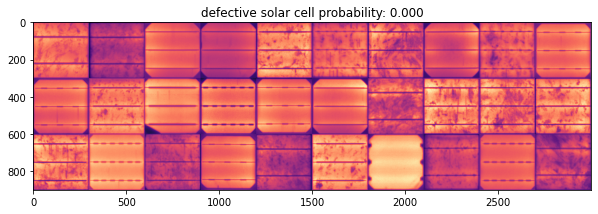

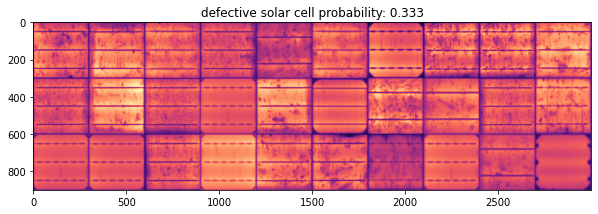

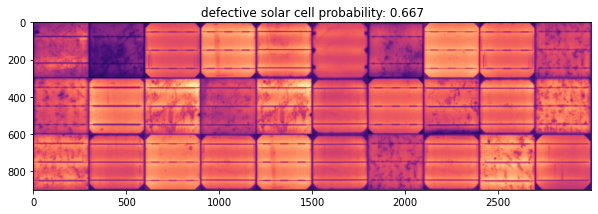

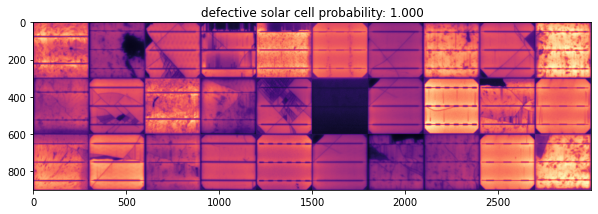

In [7]:
from utils import plot_img_samples

# lista de etiquetas
prob_classes = [0.0, 1/3, 2/3, 1.0]

# para cada una de las probabilidades
for p in prob_classes:
  
  # obtener indices correspondientes a p con np.where
  proba_samples = np.where( proba==p )[0]

  # obtener 30 random samples con np.random.choice
  proba_samples = np.random.choice( proba_samples, 30)

  # plotear
  title = 'defective solar cell probability: {:1.3f}'.format(p)
  plot_img_samples(images, proba_samples, (3, 10),
                   figsize=(10,10), title=title)

Si bien es fácil notar que los grupos funcionales y defectuosos son bastantes disímiles entre si, no sucede lo mismo entre los grupos intermedios, donde a simple vista las muestras entre ambos grupos pareciesen ser indistinguibles. Esta incertidumbre en las etiquetas de las muestras podría tornarse en un problema a la hora de entrenar nuestros modelos de clasificación, pues idealmente las distintas clases a clasificar debiesen presentar patrones y features que permitan segmentarlas con relativa facilidad.

---
# Training Data

Para paliar esta dificultad, agruparemos estas cuatro clases en solamente dos: `functional cells` y `defective cells`. Por un lado, la clase `functional cells` estará compuesto únicamente de las muestras con probabilidad `0.0`, mientras que `defective cells` agrupará el resto de las clases en el dataset. De este modo, aparte de aislar completamente las celdas que con certeza no presentan ninguna clase de defectos, dado que la función `softmax` indica la probabilidad de pertenencia a cada una de las clases, podemos utilizar esta propiedad para comparar las predicciones del modelo con las etiquetas iniciales.

In [8]:
from keras.utils import to_categorical

# transformar labels
labels = ( proba < 0.1 )

# transformar a one hot encoding
Y = to_categorical(labels, num_classes=2)

Ahora, dado que en este caso no existe riesgo de `data leakage` al dividir los datos en sets de entrenamiento `(X_train, Y_train)` y testing `(X_test, Y_test)`, podemos utilizar la función `train_test_split` de `sklearn`, la cual permite dividir de manera random los datasets ingresados en dos subonjuntos o `subsets` de entrenamiento y testing.

In [23]:
from sklearn.model_selection import train_test_split

# trasnsformar images a shape (samples, height, width, channel)
# compatible para el entrenamiento
X = np.reshape( images, (-1, 300, 300, 1) )

# realizar data splitting
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,
                                                    random_state=0)

# print sample distribution
print( 'train split: {:d} samples'.format(X_train.shape[0]) )
print( '\ntesting split: {:d} samples'.format(X_test.shape[0]) )

train split: 2099 samples

testing split: 525 samples


---
# Model Building

Para configurar nuestro modelo de clasificación utilizaremos nuevamente la librería `keras` o `tf.keras`. Keras es una API de alto nivel para la creación y el entrenamiento de modelos de deep learning. Está orientada y diseñada para la construcción de modelos de forma modular o en bloques. De este modo, ofrece un framework mucho más amigable e intuitivo para principiantes, a la vez que mantiene un estructura personalizable y versátil que permite a usuarios más avanzados incorporar nuevas ideas.

<img src="https://raw.githubusercontent.com/cherrerab/deeplearningfallas/master/workshop_02/bin/keras_logo.png" width="400">



## Model Setup

Dado que en este caso nuestras muestras o `samples` consisten en imágenes en escala de grises, implementaremos una red neuronal convolucional de clasificación (CNN) para procesar las imágenes sin perder la bidimensionalidad de su información.

Por lo general, los modelos CNN se componen de series de capas `keras.layers.Conv2D` junto con algún tipo de Pooling Layer, como las `keras.layers.MaxPool2D` o las `keras.layers.AveragePooling2D`. 

- https://keras.io/api/layers/convolution_layers/convolution2d/
- https://keras.io/api/layers/pooling_layers/

El propósito de las Pooling Layers es realizar un `down-sampling` de los `feature maps` generados por las capas `Conv2D` y de este modo, reducir significativamente la dimensionalidad de la información a medida que esta avanza en el modelo y alcanza mayores grados de abstracción.

Finalmente, para completar el modelo es necesario unir la información de los `feature maps` con la capa de salida `softmax`. Para llevar esto a cabo, el tensor de los `feature maps` es vectorizado o aplanado en una sola dimensión mediante un `keras.layers.Flatten` para luego continuar con una serie de capas `keras.layers.Dense` que se encargan de terminar el procesamiento de la información.


In [27]:
import keras
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D

# inicializar modelo keras.Sequential
model = Sequential()

# ---
# primero debemos agregar nuestra capa Input donde debemos especificar
# las dimensiones de los datos que se ingresarán al modelo
# las capas Conv2D reciben tensores de la forma (height, width, channels)
input_dim = ( 300, 300, 1)
model.add( Input( shape=input_dim ) )

# ---
# ahora debemos ir agregando nuestras capas Conv2D y Pooling.

# las keras.layers.Conv2D reciben la cantidad de filtros dentro de la capa,
# el tamaño de estos filtros y la función de activación con que operarán.
# https://keras.io/api/layers/convolution_layers/convolution2d/

# las keras.layers.MaxPooling2D reciben el tamaño de la ventana sobre
# la cual llevarán a cabo el down-sampling
# https://keras.io/api/layers/pooling_layers/max_pooling2d/

model.add( Conv2D(32, (5, 5), activation='relu', padding='same' ) )
model.add( Conv2D(32, (5, 5), activation='relu', padding='same' ) )

model.add( MaxPooling2D( pool_size=(4, 4) ) )

model.add( Conv2D(64, (5, 5), activation='relu', padding='same') )
model.add( Conv2D(64, (5, 5), activation='relu', padding='same') )

model.add( MaxPooling2D( pool_size=(2, 2) ) )

model.add( Conv2D(72, (3, 3), activation='relu', padding='same') )
model.add( Conv2D(72, (3, 3), activation='relu', padding='same') )

model.add( MaxPooling2D( pool_size=(2, 2) ) )

model.add( Conv2D(48, (3, 3), activation='relu', padding='same') )
model.add( Conv2D(32, (3, 3), activation='relu', padding='same') )

model.add( MaxPooling2D( pool_size=(2, 2) ) )

# ---
# ahora debemos ir agregando nuestras capas Dense para procesar la
# información hasta la capa de salida.
# https://keras.io/api/layers/core_layers/dense/

model.add( Flatten() )
model.add( Dropout(rate=0.2) )

model.add( Dense(units=256, activation='relu') )
model.add( Dense(units=256, activation='relu') )

model.add( Dropout(rate=0.2) )

model.add( Dense(units=128, activation='relu') )

# ---
# por último debemos configurar nuestra capa de salida
# dado que el modelo consiste en uno de clasificación emplearemos
# la función softmax, donde cada nodo indicará la probabilidad de que
# los datos correspondan a una de las etiquetas o estados de salud.
labels_num = 2
model.add( Dense(units=labels_num, activation='softmax') )

# print model.summary()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 300, 300, 32)      832       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 300, 300, 32)      25632     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 75, 75, 64)        51264     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 75, 75, 64)        102464    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 37, 37, 72)       

## Compile Model

Antes de poner a entrenar al modelo, es necesario realizar unas configuraciones adicionales. En particular, debemos especificar la función de pérdida o `loss function` que se optimizará durante el entrenamiento y el método de optimización como SGD o Adam.
- https://keras.io/api/models/model_training_apis/
- https://keras.io/api/optimizers/

In [28]:
from keras.optimizers import Adam

# configurar optimizador Adam
# https://keras.io/api/optimizers/adam/
opt = Adam(learning_rate=1e-3)

# ---
# compilar modelo siguiendo como función de pérdida
# la categorical crossentropy
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## Model Training and Callbacks
Hemos llegado a la parte final del proceso, para entrenar nuestro modelo debemos especificar los sets que utilizaremos para el proceso `(X_train, Y_train)`, la cantidad de `epochs` que durará el entrenamiento, y el `batch size` de muestras que se irán entregando al modelo a medida que este va iterativamente ajustando sus parámetros.

Ahora, dado que el entrenamiento de los modelos CNN suele demorar bastante más tiempo que un modelo Fully Connected como el del workshop anterior, suele convenir utilizar `Callbacks` durante el entrenamiento. Los `Callbacks` consisten en métodos que realizan una serie de acciones a medida que el entrenamiento se lleva a cabo. Por supuesto, `Keras` ya cuenta con una selección de `Callbacks` predefinidos listos para utilizar, como `EarlyStopping` y `ModelCheckpoint`.

- https://keras.io/api/callbacks/

En este caso, utilizaremos `ModelCheckpoint`, el cual se encargará de monitorear el `val_acc` durante el entrenamiento y guardar el modelo cada vez que este alcance un nuevo máximo. De este modo, si en algún punto llegase a ocurrir `overfitting`, se tendrá un respaldo del modelo que podrá ser importado posteriormente.

- https://keras.io/api/callbacks/model_checkpoint/


In [ ]:
from keras.callbacks import ModelCheckpoint
from utils import plot_loss_function

# ubicación en donde se guardará el modelo
save_path = '//content//model_checkpoint.h5'

# inicializar ModelCheckpoint
checkpoint = ModelCheckpoint(save_path, save_best_only=True,
                             monitor='val_accuracy', mode='max')

# realizar rutina de entrenamiento
model_history = model.fit(X_train, Y_train,
                          batch_size=64, epochs=150,
                          validation_data=(X_test, Y_test),
                          callbacks=[checkpoint])

# plot gráfico de función de pérdida
plot_loss_function(model_history, figsize=(10,4))


## Model Evaluation

Finalmente, una vez entrenado nuestro modelo debemos evaluar su desempeño. Nuevamente dada la poca cantidad de datos, utilizaremos los datos de validación como datos de testing. Para utilizar el `keras.Model` sobre nuevos datos de clasificación, conviene utilizar el método `keras.Sequential.predict`.

Por otro lado, para cargar el modelo guardado por el `ModelCheckpoint` durante el entrenamiento, se puede utilizar la función `keras.models.load_model`.

validation accuracy: 0.728


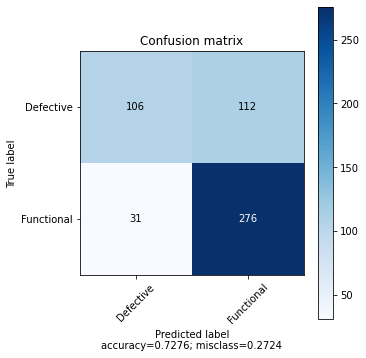

In [38]:
from keras.models import load_model

from utils import plot_confusion_matrix
from sklearn.metrics import accuracy_score

# cargar modelo (backup: workshop_03//model_backup.h5)
model_path = '//content//model_checkpoint.h5'
model = load_model(model_path)

# obtener predicciones de X_test
Y_pred = model.predict(X_test)

# para que el resultado nos sea más intuitivo transformaremos
# las etiquetas nuevamente a non one-hot-encoding
# utilizando np.argmax
labels_pred = np.argmax( Y_pred, axis=1 )
labels_true = np.argmax( Y_test, axis=1 )

# calcular accuracy de la clasificación.
accuracy = accuracy_score(labels_true, labels_pred)
print('validation accuracy: {:1.3f}'.format(accuracy))

# plot de matriz de confusión
plot_confusion_matrix(labels_true, labels_pred, ['Defective', 'Functional'])

Ahora para analizar la distribución de probabilidades predichas por la capa de salida `softmax` del modelo, podemos generar un scatter plot junto con las etiquetas originales del dataset.

model accuracy: 0.728


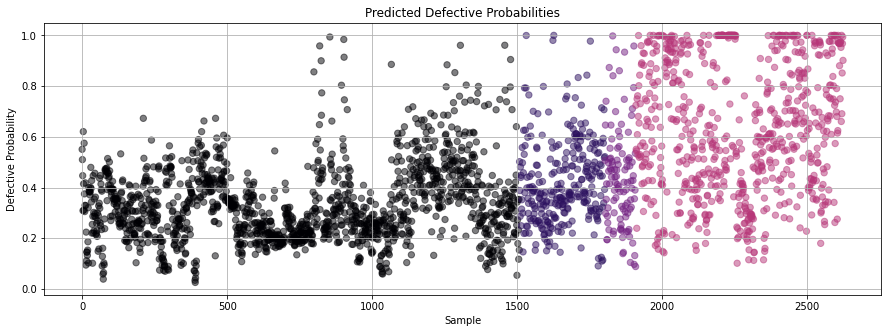

In [39]:
from sklearn.metrics import accuracy_score

# obtener predicciones sobre todo el dataset
Y_pred = model.predict(X)

# calcular accuracy de clasificación
labels_pred = np.argmax( Y_pred, axis=1 )
labels_true = np.argmax( Y, axis=1 )

accuracy = accuracy_score(labels_true, labels_pred)
print('model accuracy: {:1.3f}'.format(accuracy))

# ------------------------------------------------------------------------------
# obtener defective probability
defective_prob = Y_pred[:, 0]

# sort samples
sample_sort = np.argsort(proba)

proba_labels = proba[sample_sort]
defective_prob = defective_prob[sample_sort]

# scatter probabilities
plt.figure( figsize=(15, 5) )
plt.title('Predicted Defective Probabilities')
plt.xlabel('Sample'); plt.ylabel('Defective Probability')

plt.scatter(np.arange(defective_prob.size), defective_prob,
            c=list(proba_labels), cmap='magma', vmax=2.0, alpha=0.5, s=40)
plt.grid(True)